# Interacting with NeuroMechFly

**Author:** Sibo Wang-Chen

**Note:** The code presented in this notebook has been simplified and restructured for display in a notebook format. A more complete and better structured implementation can be found in the [examples folder of the FlyGym repository on GitHub](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/).

**Summary:** In this tutorial, we will introduce the basic concepts of interacting with the simulated fly in a Markov Decision Process using the Gym interface. As a demonstration, we will replay experimentally recorded leg kinematics during walking in the simulator.

Markov Decision Process (MDP) and the Gym API
---------------------------------------------

We formulated the control of NeuroMechFly as a partially observable Markov Decision Process (MDP). At each time step, the simulation provides the controller with an observation and, optionally, a user-defined reward. Then, the simulation receives an action from the controller and steps the physics forward accordingly. The observation space is a user-configurable subset of the state space including visual inputs, olfactory inputs, ground contacts, joint states (angles, angular velocities, and torques), and the position and velocity of the fly model within the arena. The action space includes the control signal (e.g. angles for position control) for every actuated joint (e.g. 7 degrees-of-freedom (DoFs) per leg * 6 legs) and the on/off signal for leg adhesion. This framework is easily extendable: the user can incorporate additional layers of sensory preprocessing or premotor computation into the MDP.

| ![](https://github.com/NeLy-EPFL/_media/blob/main/flygym/mdp.png?raw=true) | 
|:--:| 
| *The biomechanical model and its interaction with the environment are encapsulated as a MDP task. A user-defined controller interfaces with the task through actions (red) and observations (blue). The user can extend the MDP task by adding preprogrammed processing routines for motor outputs (purple) and sensory inputs (light blue), to modify the action and observation spaces handled by the controller.* |


Our implementation of the partially observable MDP complies with the [Gymnasium API](https://gymnasium.farama.org/). Gymnasium (a continuation of the now deprecated OpenAI Gym) is a package and standardized interface for developing and comparing control algorithms and benchmarking tasks. It provides a diverse collection of environments, ranging from classic control problems, Atari games, board games, and robotics simulations. Gym environments are designed to offer a common interface for controllers, in particular reinforcement learning agents, to interact with. This standardization makes it easier to develop and compare algorithms.

The overall steps for interacting with a Gym environment are:

1. Defining an environment
2. Reset the environment and get the initial observation
3. Interact with the environment with a loop:
   - Based on the last observation, the controller decides which actions to take
   - Step the simulation, applying the selected actions. The simulation will return you the new observation (and optionally some additional information)
   - Optional: render the simulation graphically
   - Break if certain conditions are met (e.g. task is accomplished or failed), otherwise continue

4. Close the environment and analyze the results

This process is illustrated in the following code snippet:

```Python
env = MyEnvironment(...)
obs, info = env.reset()

for step in range(1000):    # let's simulate 1000 steps max
    action = ...    # your controller decides what to do based on obs
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        break

env.close()
```

Note that the action can be selected by any means defined by the user (e.g. preprogrammed rules, algorithmic models, artificial neural networks).

### MDP specifications

Please refer to the ["MDP Task Specifications" page](https://neuromechfly.org/api_ref/mdp_specs.html#default-simulation) of the API references for the detailed specifications of the action space, the observation space, the reward, the "terminated" and "truncated" flags, and the "info" dictionary.

## Example: Kinematic replay of experimentally recorded behavior

We now move on to an example where we kinematically replay some experimentally recorded walking behaviors. Specifically, we recorded a tethered fly walking on an air-suspended spherical treadmill using seven zoomed-in cameras from different angles. We then estimated the 3D positions of keypoints on the joints using DeepFly3D (Günel et al., *Elife* 2019) and used inverse kinematics to calculate the angle at each DoF. With these we will use a PD controller to actuate the DoFs of the simulated fly at using these exact angles to see if the fly can walk untethered on flat terrain, as shown in the original NeuroMechFly paper (Lobato-Rios et al., *Nature Methods* 2022).

We start with the necessary imports:

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

from flygym import Fly, ZStabilizedCamera, SingleFlySimulation, get_data_path
from flygym.preprogrammed import all_leg_dofs

Let's define some simulation parameters:

In [2]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

We can now load recorded kinematics that are included with the FlyGym package:

In [3]:
data_path = get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

The dataset is provided at 2000 Hz. We will try to run the simulation at $\Delta t=0.0001s$ (10000 Hz), so let's interpolate it 5x:

In [4]:
target_num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[joint])

We can visualize the time series of DoF angles:

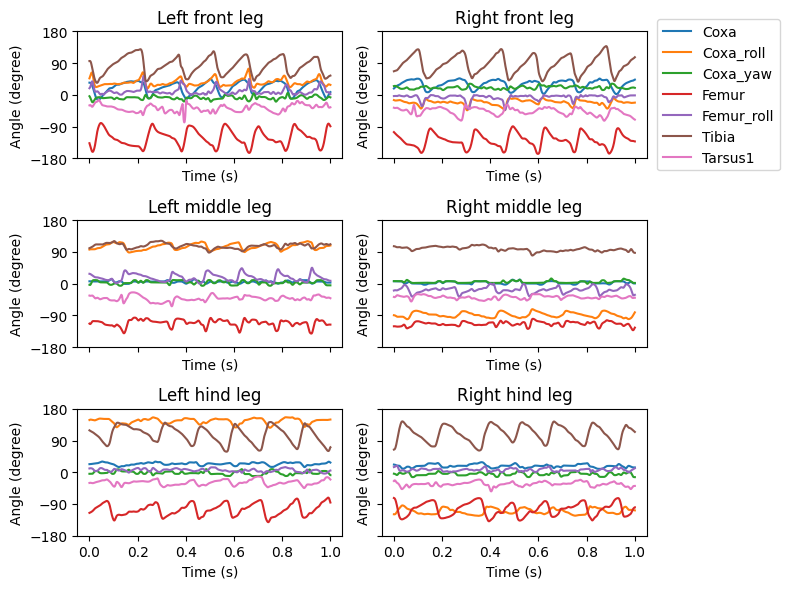

In [5]:
fig, axs = plt.subplots(
    3, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.ravel()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(output_t, np.rad2deg(data_block[j, :]), label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

output_dir = Path("outputs/")
output_dir.mkdir(exist_ok=True, parents=True)
fig.savefig(output_dir / "kin_replay_joint_dof_time_series.png")

Now we can create a NeuroMechFly simulation instance and play out the recorded kinematics in the MDP loop:

In [6]:
fly = Fly(
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)

cam = ZStabilizedCamera(
    attachment_point=fly.model.worldbody,
    camera_name="camera_left",
    targeted_fly_names=[fly.name],
    play_speed=0.1,
    draw_contacts=True,
)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
)
obs, info = sim.reset()
for i in trange(target_num_steps):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

100%|██████████| 10000/10000 [00:35<00:00, 279.71it/s]


To save the rendered video:

In [7]:
cam.save_video(output_dir / "kinematic_replay.mp4")

In [8]:
from IPython.display import Video

Video(output_dir / "kinematic_replay.mp4")

We can inspect the observation at the last step to see if they are consistent with our expectations:

In [9]:
for k, v in obs.items():
    print(f"{k}: shape {v.shape}")

joints: shape (3, 42)
fly: shape (4, 3)
contact_forces: shape (30, 3)
end_effectors: shape (6, 3)
fly_orientation: shape (3,)
cardinal_vectors: shape (3, 3)


The basic NeuroMechFly simulation always returns 0 as the reward. It always returns False for the `terminated` and `truncated` flags. The `info` is also empty. The user can extend the `NeuroMechFly` class to modify these behaviors.

In [10]:
print(f"reward: {reward}")
print(f"terminated: {terminated}")
print(f"truncated: {truncated}")
print(f"info: {info}")

reward: 0
terminated: False
truncated: False
info: {'flip': False}


## Exercise 1: Exploring the Effects of Simulation Parameters

In this exercise, we will adjust various simulation parameters to observe their impact on *Drosophila* locomotion. Most simulation parameters are passed to the `Fly` class, allowing individual flies to have unique configurations. However, certain parameters like `timestep` and `gravity` are passed to the `Simulation` class as they are shared globally across all instances of the `Fly` class. For detailed information on these parameters, refer to the API documentation for the [Fly class](https://neuromechfly.org/api_ref/fly.html) and the [Simulation class](https://neuromechfly.org/api_ref/simulation.html).

To begin, modify the cell below to run simulations with different values of `actuator_gain` for the `Fly` class (e.g., 10, 45 (default), and 90). Observe and analyze how changes in `actuator_gain` influence the walking behavior of the fly. What happens when `actuator_gain` is too low or too high?

In [14]:
fly = Fly(
    init_pose="tripod",
    actuated_joints=actuated_joints,
    control="position",
    # ==========================================================================
    # TODO: modify the actuator_gain
    actuator_gain=45,
    # ==========================================================================
)

cam = ZStabilizedCamera(
    attachment_point=fly.model.worldbody,
    camera_name="camera_left",
    targeted_fly_names=[fly.name],
    play_speed=0.1,
    draw_contacts=True,
)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
)
obs, info = sim.reset()

for i in trange(target_num_steps):
    joint_pos = data_block[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

cam.save_video(output_dir / "kinematic_replay_actuator_gain_changed.mp4")
Video(output_dir / "kinematic_replay_actuator_gain_changed.mp4")

100%|██████████| 10000/10000 [00:41<00:00, 238.72it/s]


## Exercise 2: extract kinematics for one step cycle

In this section, we will try to extract one complete the kinematics of one complete walking cycle, which can be repeated for an unlimited number of times to allow the fly to walk further. To accomplish this, we will locate the time interval for each walking cycle by detecting peaks in one of the joint angles, resample the kinematics of the walking cycles so that they are of the same length, and then average them.

In [21]:
from scipy.signal import find_peaks

# get the joint angle of the right hind leg tibia
rh_tibia_angle = data_block[actuated_joints.index("joint_RHTibia")]

# ===============================================================================================
# TODO: detect peaks in the tibia angle of the right hind leg using scipy.signal.find_peaks
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html for usage
peak_frame_indices = find_peaks(rh_tibia_angle)[0]
# ===============================================================================================

cycle_n_frames = round(np.diff(peak_frame_indices).mean())

Text(0.5, 1.0, 'Right hind tibia')

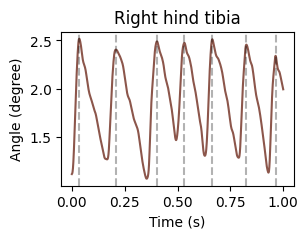

In [23]:
# plot the tibia angle of the right hind leg with detected peaks
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(output_t, rh_tibia_angle, color="C5")

for t in peak_frame_indices * timestep:
    ax.axvline(t, color="k", ls="--", alpha=0.3)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Angle (degree)")
ax.set_title("Right hind tibia")

In [18]:
from scipy.interpolate import interp1d

data_block_cycle = np.zeros((len(actuated_joints), cycle_n_frames))

for a, b in np.lib.stride_tricks.sliding_window_view(peak_frame_indices, 2):
    old_indices = np.arange(b - a)
    new_indices = np.linspace(0, old_indices.max(), cycle_n_frames)
    data_block_cycle += interp1d(old_indices, data_block[:, a:b])(new_indices)

data_block_cycle /= len(peak_frame_indices) - 1

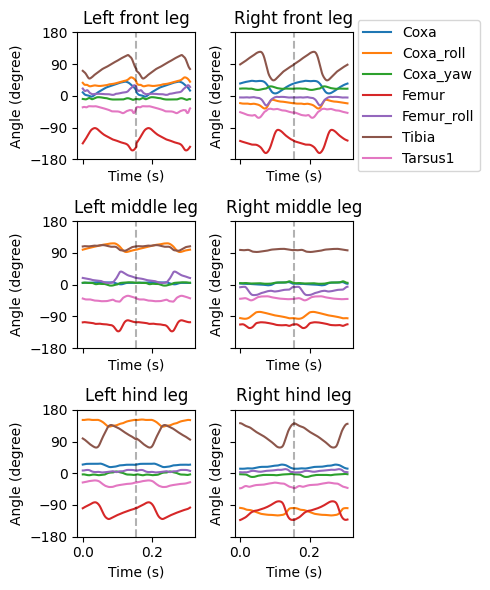

In [24]:
# plot locomotor kinematics for two cycles
fig, axs = plt.subplots(
    3, 2, figsize=(5, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        angles = np.tile(np.rad2deg(data_block_cycle[j, :]), 2)
        ax.plot(np.arange(len(angles)) * timestep, angles, label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    ax.axvline(cycle_n_frames * timestep, color="k", ls="--", alpha=0.3)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

In [25]:
# replay the locomotor kinematics for two cycles
fly = Fly(
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)

cam = ZStabilizedCamera(
    attachment_point=fly.model.worldbody,
    camera_name="camera_left",
    targeted_fly_names=[fly.name],
    play_speed=0.1,
    draw_contacts=True,
)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
)
obs, info = sim.reset()

for i in trange(cycle_n_frames * 2):
    joint_pos = data_block_cycle[:, i % cycle_n_frames]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

cam.save_video(output_dir / "kinematic_replay_2_cycles.mp4")

Video(output_dir / "kinematic_replay_2_cycles.mp4")

100%|██████████| 3096/3096 [00:11<00:00, 274.33it/s]


## Exercise 3: alter locomotor kinematics
With the same simulation parameters and number of simulation steps, can you make the fly walk approximately twice as fast? (In *Drosophila*, changes in stance duration largely regulate walking speed, while stance amplitude and swing duration remain relatively constant (DeAngelis et al., 2019; Wosnitza et al., 2012). For simplicity, we will decrease both stance and swing durations here.)

In [30]:
fly = Fly(
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)

cam = ZStabilizedCamera(
    attachment_point=fly.model.worldbody,
    camera_name="camera_left",
    targeted_fly_names=[fly.name],
    play_speed=0.1,
    draw_contacts=True,
)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
)
obs, info = sim.reset()

for i in trange(target_num_steps):
    # =========================================================================
    # TODO: replay the locomotor kinematics at 2× speed by skipping frames
    # you will find the data_block_cycle and cycle_n_frames variables useful
    joint_pos = data_block_cycle[:, 2*i % cycle_n_frames]
    # =========================================================================
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

cam.save_video(output_dir / "kinematic_replay_fast.mp4")
Video(output_dir / "kinematic_replay_fast.mp4")

100%|██████████| 10000/10000 [00:33<00:00, 300.02it/s]


Can you make the fly backwards?

In [33]:
fly = Fly(
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)

cam = ZStabilizedCamera(
    attachment_point=fly.model.worldbody,
    camera_name="camera_left",
    targeted_fly_names=[fly.name],
    play_speed=0.1,
    draw_contacts=True,
)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
)
obs, info = sim.reset()

for i in trange(target_num_steps):
    # =========================================================================
    # TODO: modify the index to make the fly walk backwards
    joint_pos = data_block_cycle[:, -i % cycle_n_frames]
    # =========================================================================
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

cam.save_video(output_dir / "kinematic_replay_backwards.mp4")
Video(output_dir / "kinematic_replay_backwards.mp4")

100%|██████████| 10000/10000 [00:35<00:00, 278.35it/s]


## Exercise 4: engineering new behaviors
Obtaining joint angles for realistic walking requires recording a real fly from multiple views and 3D pose estimation. For simpler behaviors, we might be able to design them by hand. Here, we will use the MuJoCo viewer to find the set of joint angles for poses that we want the fly to achieve, and then interpolate between these sets of joint angles to create a new behavior. Here is how the GUI works:

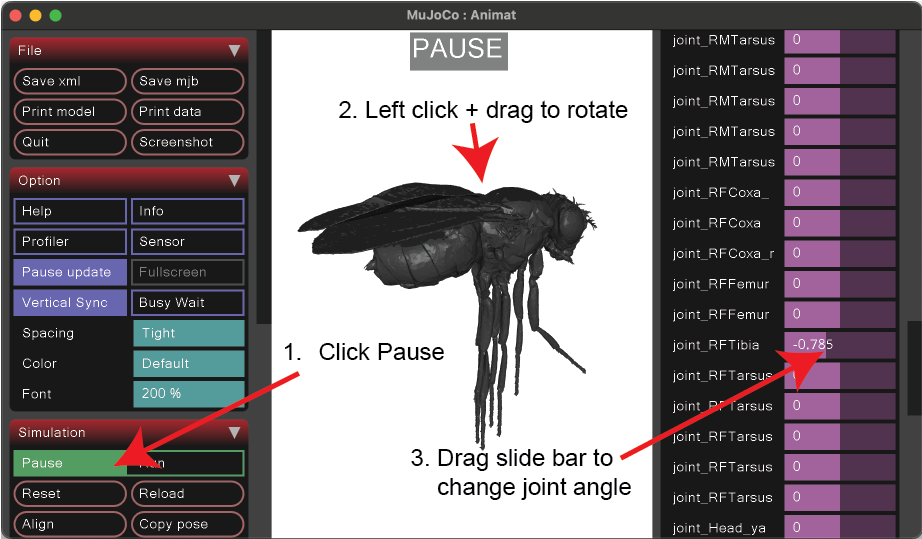

You may launch the MuJoCo viewer by running the cell below or by starting a new terminal and running the following command:
```bash
conda activate flygym
python -m mujoco.viewer --mjcf ~/flygym/flygym/data/mjcf/neuromechfly_seqik_kinorder_ypr.xml
```
Change the path to the desired mjcf file according to the location of the `flygym` repository on your system.

In [39]:
# modify the path according to the location of the flygym repository on your machine
# for example, if the repository is in C:/Users/username/flygym, the path should be
# C:/Users/username/flygym/flygym/data/mjcf/neuromechfly_seqik_kinorder_ypr.xml
!python -m mujoco.viewer --mjcf ~/flygym/flygym/data/mjcf/neuromechfly_seqik_kinorder_ypr.xml

^C


Try to adjust the joint angles to achieve the poses shown below. After you have achieved the desired pose, you can copy the joint angles by clicking "Copy pose" in the simulation tab of the navigation bar on the left. Paste the copied strings in the code cell below and then run it to visualize the behavior.

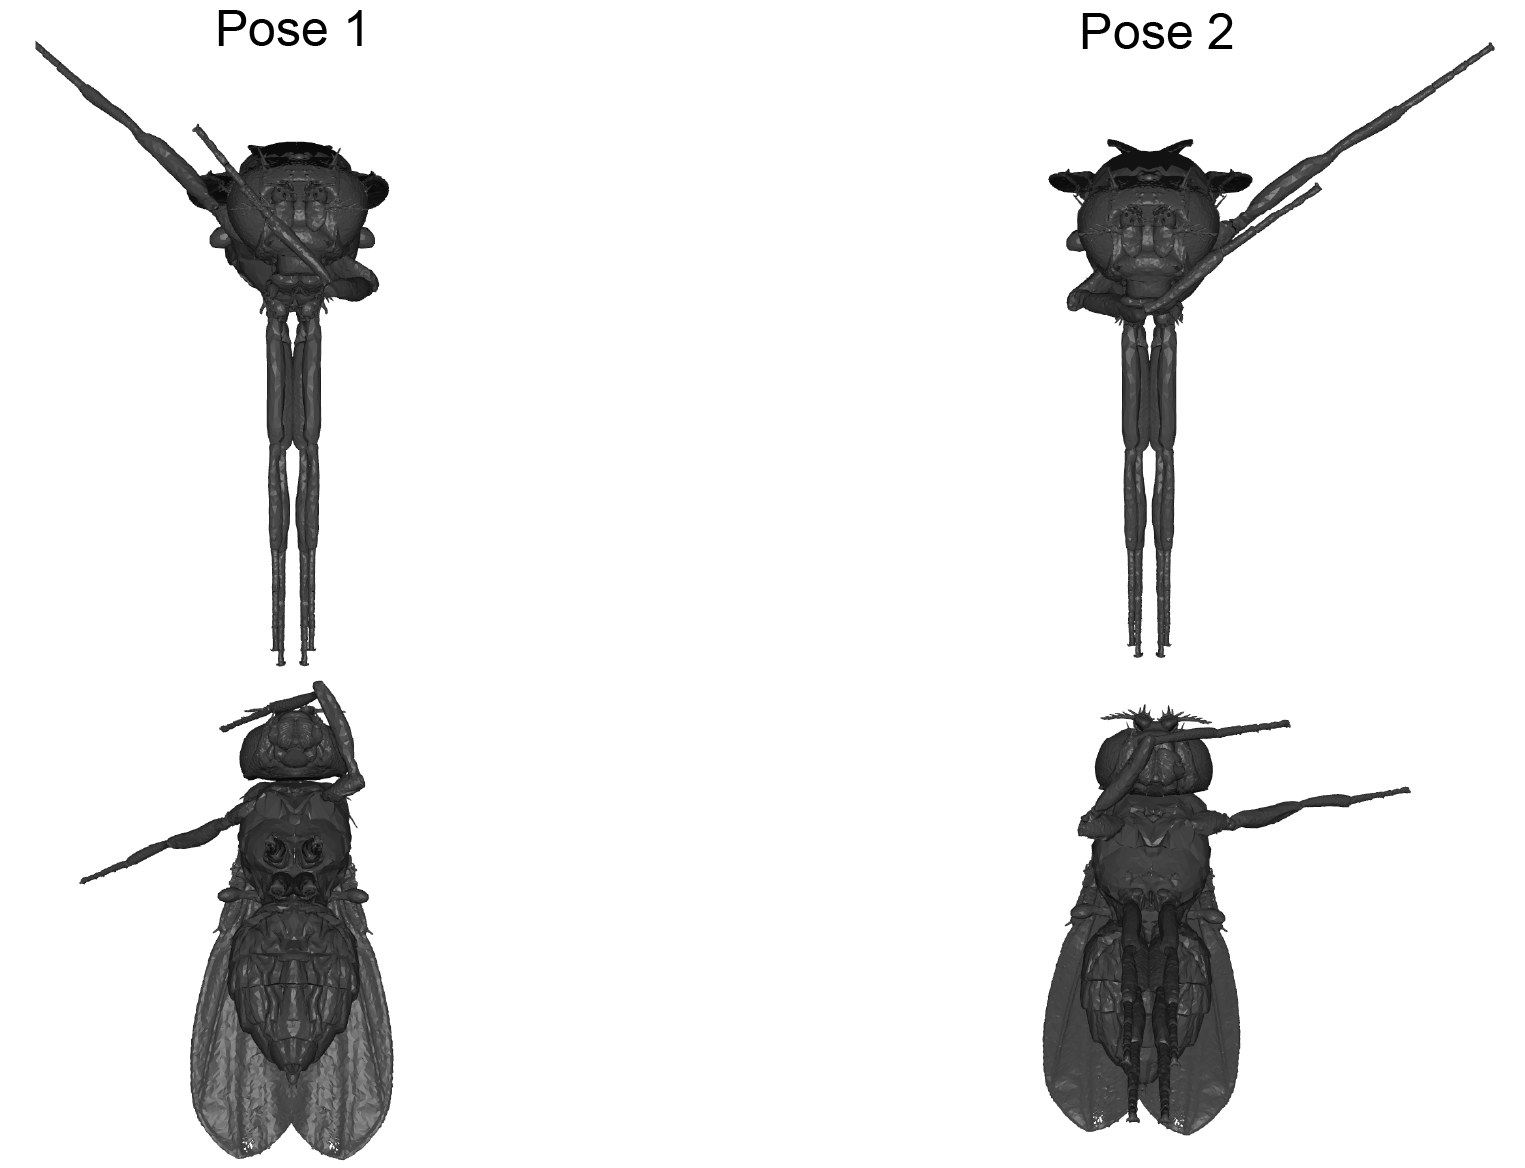

In [42]:
from flygym.preprogrammed import get_preprogrammed_pose
from scipy.interpolate import interp1d

def get_joint_angles(copied_string, actuated_joints):
    import re
    joint_names = re.findall('<joint name="(joint_\\w+)"', Fly().model.to_xml_string())
    all_joints = copied_string.split("'")[1].split(" ")
    joints = np.array([float(all_joints[joint_names.index(joint)]) for joint in actuated_joints])
    return joints

joint_angles_list = []

init_pose = get_preprogrammed_pose("tripod")
joint_angles_list.append([init_pose.joint_pos[joint] for joint in actuated_joints])
joint_angles_list.append(joint_angles_list[0])

################################################################################
# TODO: paste the copied string of the 1st pose here.
# It should look something like: <key qpos='...'/>
copied_string1 = "<key qpos='-0.00550311 0.00043856 0 -1.85354 1.7593 1.28806 0.00227276 0.0104454 0.01427 0.0121684 0.0072451 0.012235 -0.0104524 0.000178911 0.0276771 0.0272303 -0.00554162 -0.0206519 -0.0204825 -0.0323051 -0.0259073 -0.0145084 0.00582621 -0.00595407 4.52834e-05 0.0180094 0.00255421 -0.0054383 -0.019187 -0.0209751 -0.0284893 -0.0282765 -0.0185422 -0.012235 -0.0104524 -0.000178911 0.0276771 -0.0272303 -0.00554161 -0.0206519 -0.0204824 -0.0323051 -0.0259073 -0.0145084 -0.00582621 -0.00595407 -4.52834e-05 0.0180093 -0.0025542 -0.00543828 -0.0191871 -0.0209751 -0.0284893 -0.0282765 -0.0185422 0.00550312 0.000438518 -1.06814 -1.94779 -1.5708 -0.15708 -0.15708 0.0104454 0.01427 0.0121684 0.0072451 -0.0248011 1.2742 -1.1263e-05 -0.0552364 -0.35728 0.0135348 -0.316341 -0.671455 -0.307597 -1.39832 0.425587 0.0913847 0.112021 -0.35396 0.027906 0.317064 -0.671412 0.307611 1.39779 0.425491 -0.0913003'/>"
################################################################################
joint_angles_list.append(get_joint_angles(copied_string1, actuated_joints))

joint_angles_list.append(joint_angles_list[0])

################################################################################
# TODO: paste the copied string of the 2nd pose here
copied_string2 = "<key qpos='0.439824 -0.753984 1.28806 -1.31947 0.408408 -0.345576 0.00227276 0.0104454 0.01427 0.0121684 0.0072451 0.012235 -0.0104524 0.000178911 0.0276771 0.0272303 -0.00554162 -0.0206519 -0.0204825 -0.0323051 -0.0259073 -0.0145084 0.00582621 -0.00595407 4.52834e-05 0.0180094 0.00255421 -0.0054383 -0.019187 -0.0209751 -0.0284893 -0.0282765 -0.0185422 -0.012235 -0.0104524 -0.000178911 0.0276771 -0.0272303 -0.00554161 -0.0206519 -0.0204824 -0.0323051 -0.0259073 -0.0145084 -0.00582621 -0.00595407 -4.52834e-05 0.0180093 -0.0025542 -0.00543828 -0.0191871 -0.0209751 -0.0284893 -0.0282765 -0.0185422 0.00550312 0.000438518 -0.282744 -1.91638 -1.85354 1.7593 -0.15708 0.0104454 0.01427 0.0121684 0.0072451 -0.0248011 1.2742 -1.1263e-05 -0.0552364 -0.35728 0.0135348 -0.316341 -0.671455 -0.307597 -1.39832 0.425587 0.0913847 0.112021 -0.35396 0.027906 0.317064 -0.671412 0.307611 1.39779 0.425491 -0.0913003'/>"
################################################################################
joint_angles_list.append(get_joint_angles(copied_string2, actuated_joints))

joint_angles_list = np.array(joint_angles_list)
# set middle and hind leg joint angles to be the same as those from the initial pose
joint_angles_list[:, 7:21] = joint_angles_list[0, 7:21]
joint_angles_list[:, 28:] = joint_angles_list[0, 28:]

# move the middle legs forward to stabilize the fly
joint_angles_list[:, all_leg_dofs.index("joint_LMCoxa")] = joint_angles_list[:, all_leg_dofs.index("joint_RMCoxa")] = -0.4

# interpolate the joint angles
target_num_steps2 = 3000
joints_interp = interp1d(np.linspace(0, 1, len(joint_angles_list)), joint_angles_list, axis=0)(np.linspace(0, 1, target_num_steps2))

fly = Fly(
    init_pose=init_pose,
    actuated_joints=actuated_joints,
    control="position",
)

cam = ZStabilizedCamera(
    attachment_point=fly.model.worldbody,
    camera_name="camera_front",
    targeted_fly_names=[fly.name],
    play_speed=0.1,
    draw_contacts=False,
)
cam._cam.mode = "track"
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
)
obs, info = sim.reset()

for i in trange(target_num_steps2):
    action = {"joints": joints_interp[i]}
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

cam.save_video(output_dir / "kinematic_replay_new_behavior.mp4")
Video(output_dir / "kinematic_replay_new_behavior.mp4")

100%|██████████| 3000/3000 [00:11<00:00, 257.05it/s]
